# 사물 이미지 분류 경진대회

## 데이터 불러오기

In [361]:
import os
import pandas as pd
import warnings
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

warnings.filterwarnings('ignore')

In [697]:
## 데이터를 불러올 함수를 정의
def load_CIFAR10(path, train=True):
    '''
    If train then
        path -> folder1, folder2, ..., folder10
        folder1 -> img1, img2, ..., img5000
        ...
        folder10 -> img1, img2, ..., img5000
        
    If test then
        path -> img1, img2, ..., img5000
    '''
    from tqdm import tqdm
    path = path ## 이미지 파일들이 담겨있는 폴더들이 담겨있는 파일 경로
    images = [] ## 이미지 리스트
    labels = [] ## 라벨 리스트
    
    ## train
    if train:
        for foldername in tqdm(os.listdir(path)): ## 이미지 파일들이 담겨있는 폴더 이름(=라벨)
            img_path = path + foldername + '/'
            for img in os.listdir(img_path):  ## 폴더에 담겨있는 이미지들
                an_img = Image.open(img_path + img)  ## 이미지를 불러온다
                img_array = np.array(an_img)  ## 이미지를 넘파이 어레이로 변경한다
                images.append(img_array)      ## 이미지 리스트에 넘파이 어레이로 된 이미지를 추가한다
                label = foldername            ## 라벨을 가져온다
                labels.append(label)          ## 라벨 리스트에 라벨을 추가한다
                
        return images, labels ## 이미지와 라벨을 반환
                
    ## test
    for img in tqdm(os.listdir(path)):
        an_img = Image.open(path + img)  
        img_array = np.array(an_img)  
        images.append(img_array)               
        
    return images ## 이미지를 반환(test는 라벨이 없다)

In [217]:
file_path = 'C:/Users/Jaesu/Dataset/CIFAR10_dataset/'

In [220]:
train_file_path = file_path + 'train/'
test_file_path = file_path + 'test/'

In [219]:
train_images, train_labels = load_CIFAR10(path=train_file_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.66s/it]


In [251]:
test_images = load_CIFAR10(path=test_file_path, train=False)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 118.23it/s]


`-` 신기한게 처음에 이미지 불러올 땐 5분 걸렸는데 다시 불러오니 22초 걸림

`-` 라벨 인코딩을 해주자

In [78]:
from sklearn.preprocessing import LabelEncoder

In [229]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
train_labels = train_labels.reshape(-1,1)
train_labels = torch.Tensor(train_labels).reshape(-1).type(torch.LongTensor)

In [264]:
train_images.shape, train_labels.shape, test_images.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3))

## 간단한 EDA

`-` 무작위로 이미지를 뽑아 시각화

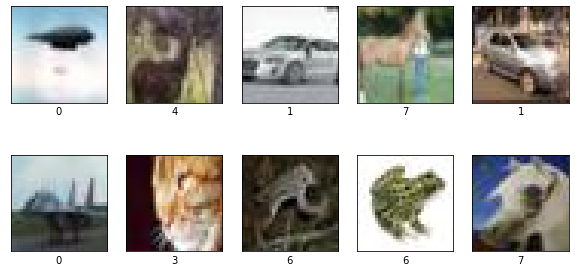

In [85]:
plt.figure(figsize=[10, 5])
for i in range(10):
    import random
    num = random.randint(0, 50000)
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(train_labels[num][0])
    plt.imshow(train_images[num])
plt.show()

`-` 라벨 빈도수 확인

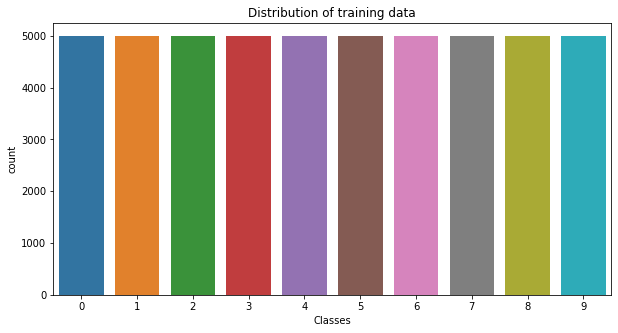

In [89]:
plt.figure(figsize=[10,5])
sns.countplot(train_labels.ravel())
plt.title('Distribution of training data')
plt.xlabel('Classes')
plt.show()

## Dataset 준비

In [331]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

In [679]:
## 데이터 변환 방식을 정의(Agumentation)
def get_transform(train=True):
    ''' 
    If train data -> RandomResizedCrop(scale: 0.6~1.0) -> HorizontalFlip(prob: 50%) -> RandomRotation(degree: -30~30)
    If test data -> nothing
    Lastly, Use ToTensor() 
    '''
    trans = transforms.Compose([
        transforms.ToTensor(), ## 0~255 -> 0.0~1.0
    ])
    
    if train:
        trans = transforms.Compose([
            transforms.ToPILImage(), ## 텐서를 PIL이미지로 바꾸고 이미지를 변형시킨다 ## 변형은 PIL이미지 타입일 때 가능
            transforms.RandomResizedCrop(size=32, scale=(0.6, 1.0)), 
            transforms.RandomHorizontalFlip(p=0.5), 
            transforms.RandomRotation(degrees=30),
            transforms.ToTensor(), ## PIL이미지를 다시 텐서로 변환
        ])

    return trans ## 데이터 변환 방식을 반환

In [658]:
class CustomDataset(Dataset):
    def __init__(self, X: np.array, labels=None, transform=None, target_transform=None):
        self.X = X  ## 넘파이 어레이로 변환된 이미지
        self.labels = labels  ## 라벨
        self.transform = transform  ## X 변환방법
        self.target_transform = target_transform ## 라벨 변환방법
    
    def __getitem__(self, idx):
        numpy_img = self.X[idx]
        if self.transform is not None: 
            transformed_img = self.transform(numpy_img) 
            
        if self.labels is not None:
            label = self.labels[idx]
            if self.target_transform:
                label = self.target_transform(label)             
            return transformed_img, label  ## train   
        
        return transformed_img  ## test
    
    def __len__(self):
        return len(self.X) ## 데이터 개수 반환

In [656]:
transform_train = get_transform() ## train
transform_test = get_transform(train=False) ## test

In [644]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=22)
X_test = copy.deepcopy(test_images)

In [645]:
print('X_train 크기:', X_train.shape)
print('X_valid 크기:', X_valid.shape)
print('X_test  크기:', X_test.shape)

X_train 크기: (40000, 32, 32, 3)
X_valid 크기: (10000, 32, 32, 3)
X_test  크기: (10000, 32, 32, 3)


## 모델 설계

`-` 학습은 gpu없으면 너무 오래걸려서 colab에서 해야됨

`-` 아래는 모델이 잘 돌아가는지 확인용으로 작성함

In [618]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = models.resnet18(pretrained=False) ## Resnet18 아키텍쳐사용
        self.drop = nn.Dropout(0.25)
        self.fc = nn.Linear(1000, 10) ## resnet18의 최종 output차원은 1000
        
    def forward(self, x):
        x = self.model(x)
        x = self.drop(x)
        x = self.fc(x)
        return x

In [619]:
## 랜덤 시드 고정
torch.manual_seed(22)

In [620]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [672]:
learning_rate = 0.001
epochs = 1 ## test 용도, 나중에 할 땐 10으로 변경
batch_size = 100

`-` train 데이터셋과 데이터로더

In [622]:
train_dataset = CustomDataset(X=X_train, labels=y_train, transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

`-` valid 데이터셋과 데이터로더

In [657]:
valid_dataset = CustomDataset(X=X_valid, labels=y_valid, transform=transform_test)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [624]:
total_batch = len(train_dataloader)
print(f'총 배치의 수 : {total_batch}')

총 배치의 수 : 400


In [632]:
## 모델 정의
net = CustomModel().to(device)

In [633]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)   ## 비용 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

`-` 이제 모델을 훈련시키자

In [652]:
net.train() ## 훈련모드
for epoch in range(epochs):
    avg_loss = 0

    for X, y in tqdm(train_dataloader): # 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블.
        X = X.to(device)
        y = y.to(device).reshape(-1).type(torch.LongTensor) ## shape를 2d에서 1d로 맞춰주고 type을 float32에서 int64로 바꿔줌

        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = net(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y) ## 오차를 계산
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트

        avg_loss += (loss / total_batch)

    print('[Epoch: {:>4}] loss = {:>.9}'.format(epoch + 1, avg_cost))

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [08:23<00:00,  1.26s/it]

[Epoch:    1] loss = 3.02643585


In [654]:
## accuracy 계산
def compute_acc(true, pred):
    return sum(true == pred) / len(true)

In [671]:
net.eval() ## 평가모드
valid_losses = list()

with torch.no_grad():
    for X, y in tqdm(valid_dataloader):
        X = X.to(device)
        y = y.reshape(-1).type(torch.LongTensor).to(device)
        yhat = net(X)
        loss = loss_fn(yhat,y)
        valid_losses.append(loss)
print(f'Valid Loss : {np.mean(valid_losses):>8f}') ## 테스트 루프 종료시 평균 loss를 출력

acc = compute_acc(y.detach().cpu().numpy(), yhat.detach().cpu().numpy().argmax(-1))
print(f'Valid accuracy : {acc:>8f}') ## 테스트 루프 종료시 accuracy를 출력

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.80it/s]

Valid Loss : 2.398515
Valid accuracy : 0.120000
